In [10]:
import os.path as op
import scipy.io
import numpy as np
import mne
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
from mne.channels import find_ch_adjacency
from mne.stats import permutation_cluster_1samp_test, ttest_1samp_no_p
from functools import partial
import seaborn as sns
import json
import pandas as pd

In [13]:
ages = ['three', 'six','twelve'] 
file_paths = {
    'three': 'processed_psd_three_V2.mat',
    'six' : 'processed_psd_six_V2.mat',
    'twelve' : 'processed_psd_twelve_V2.mat'
}

df = pd.read_csv('/home/common/bonaiuto/devmobeta/derivatives/montage_BV_64.csv', delimiter=',')

phi_rad = np.radians(df['Phi'].values)
theta_rad = np.radians(df['Theta'].values)

x = np.sin(theta_rad) * np.cos(phi_rad)
y = np.sin(theta_rad) * np.sin(phi_rad)
z = np.cos(theta_rad)

ch_pos = {}
for i, name in enumerate(df['Name']):
    ch_pos[name] = np.array([x[i], y[i], z[i]])

montage = mne.channels.make_dig_montage(ch_pos=ch_pos)
info = mne.create_info(montage.ch_names, 500, 'eeg').set_montage(montage)
ch_names_no_cz = [ch for ch in info['ch_names'] if ch != 'Cz']

info_no_cz = mne.pick_info(info, mne.pick_channels(info['ch_names'], ch_names_no_cz))

/tmp/ipykernel_44188/3474884513.py:23: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = mne.create_info(montage.ch_names, 500, 'eeg').set_montage(montage)


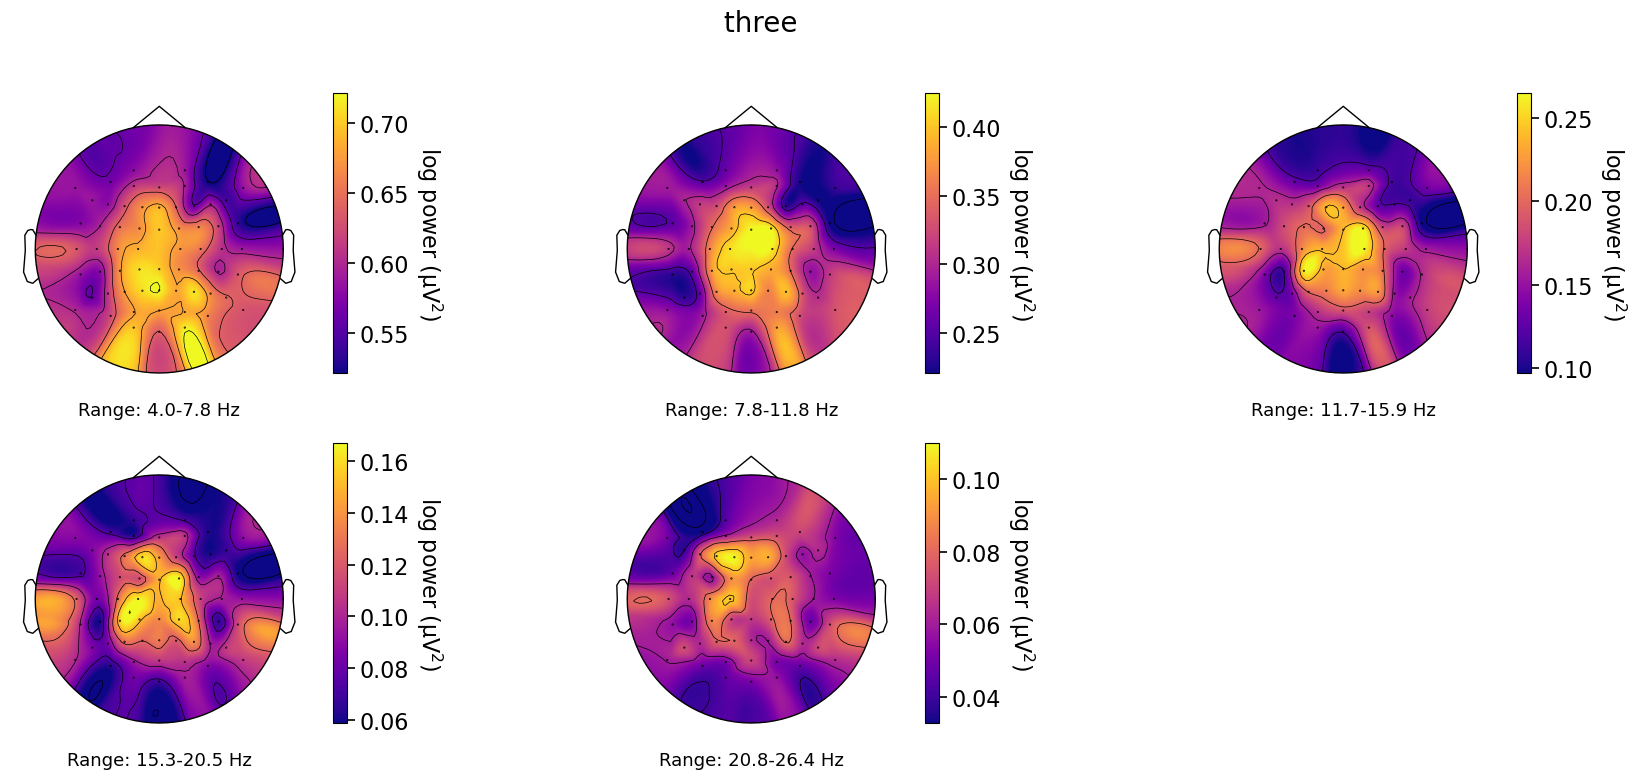

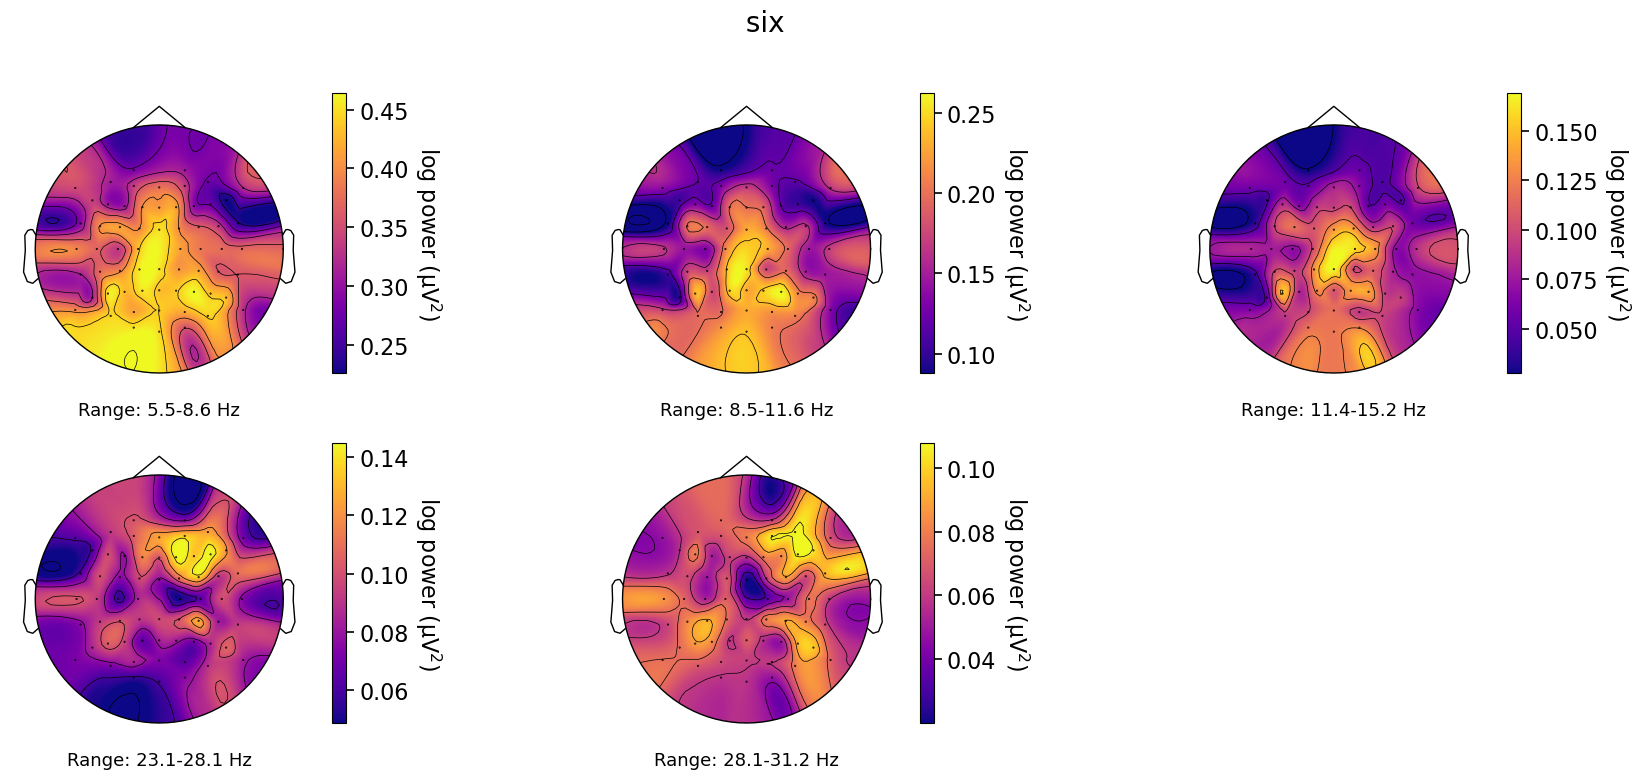

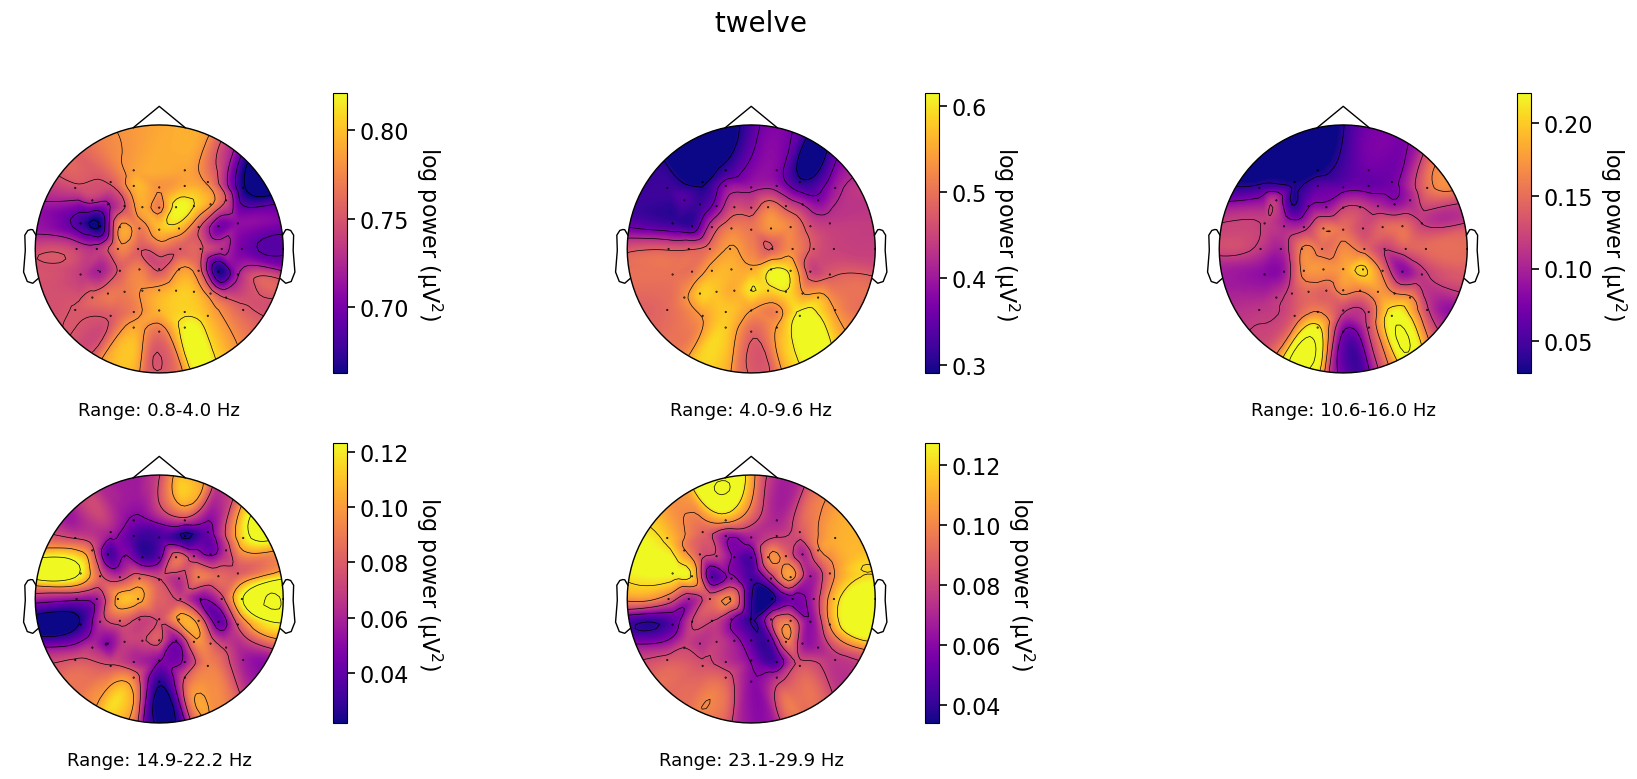

In [14]:
color_ranges = {
     'three': [
       [ 4.05,  7.85],
       [ 7.75, 11.85],
       [11.7 , 15.9 ],
       [15.3 , 20.5 ],
       [20.8 , 26.4 ],
    ],
    'six': [
       [ 5.45,  8.55],
       [ 8.5 , 11.6 ],
       [11.45, 15.15],
       [23.1 , 28.1 ],
       [28.15, 31.25],
    ],
    'twelve': [
       [ 0.75,  3.95],
       [ 4.  ,  9.6 ],
       [10.6 , 16.  ],
       [14.95, 22.25],
       [23.05, 29.95],
    ]
}

plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.2,
    'svg.fonttype': 'none',
    'text.usetex': False
})

for age in ages:
    fig = plt.figure(figsize=(18, 8), facecolor='w')
    n_rows = 2
    n_cols = int(np.ceil(len(color_ranges[age]) / n_rows))
    gs = fig.add_gridspec(n_rows, n_cols)
    
    fname = file_paths[age]  
    data = scipy.io.loadmat(fname)  
    periodic = data['periodic']  
    periodic[periodic < 0] = 0  
    frex = data['frex'][0, :]  
    
    for range_idx, color_range in enumerate(color_ranges[age]):
        
        frex_idx = np.where((frex >= color_range[0]) & (frex <= color_range[1]))[0]
        
        mean_range = np.nanmean(np.nanmean(periodic[:, :, frex_idx], axis=2), axis=0)
        
        row = range_idx // n_cols
        col = range_idx % n_cols
        ax = fig.add_subplot(gs[row, col])

        
        mean_range = mean_range.ravel()  
        
        tm, cm = mne.viz.plot_topomap(
            mean_range, info_no_cz, cmap='plasma', axes=ax, show=False,
            contours=6, vlim=(np.min(mean_range), np.max(mean_range)),
            outlines='head',
            sphere=1.5
        )
        
        ax.text(0.5, -0.15, f'Range: {color_range[0]:.1f}-{color_range[1]:.1f} Hz', 
                horizontalalignment='center', transform=ax.transAxes, fontsize=13)
        
        cbar = plt.colorbar(tm, fraction=0.06, pad=0.05)
        cbar.set_label('log power (µV$^2$)', rotation=270, labelpad=25)
    
    plt.suptitle(f' {age}', fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97
                        ])  
    
    plt.savefig(f'/home/ldurieux/devmobeta_grasp/topoplots_{age}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)  

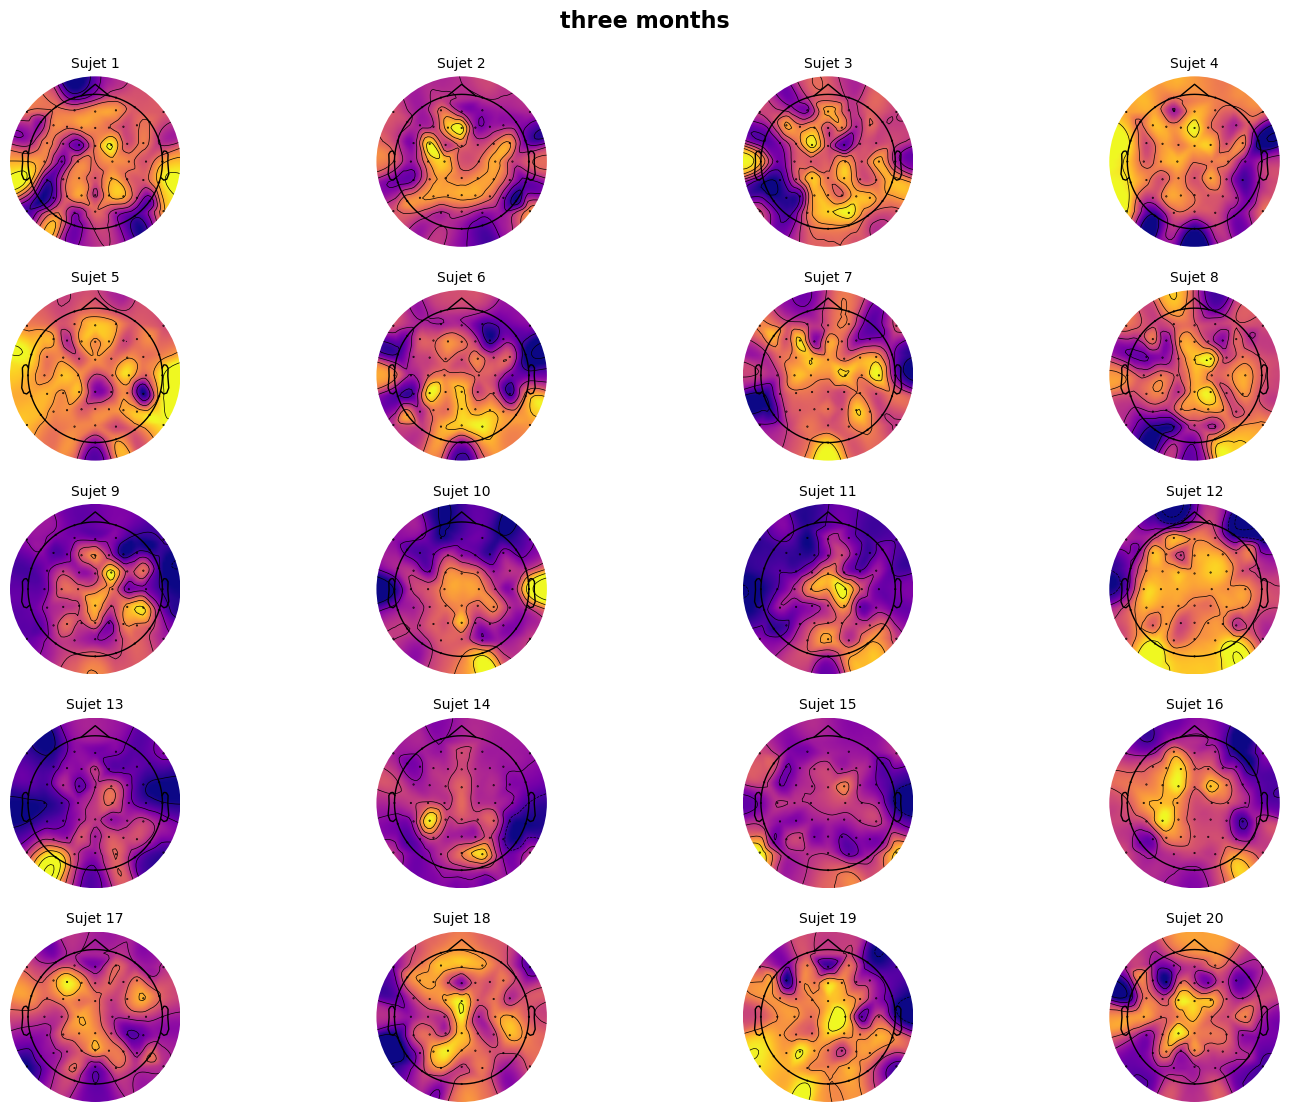

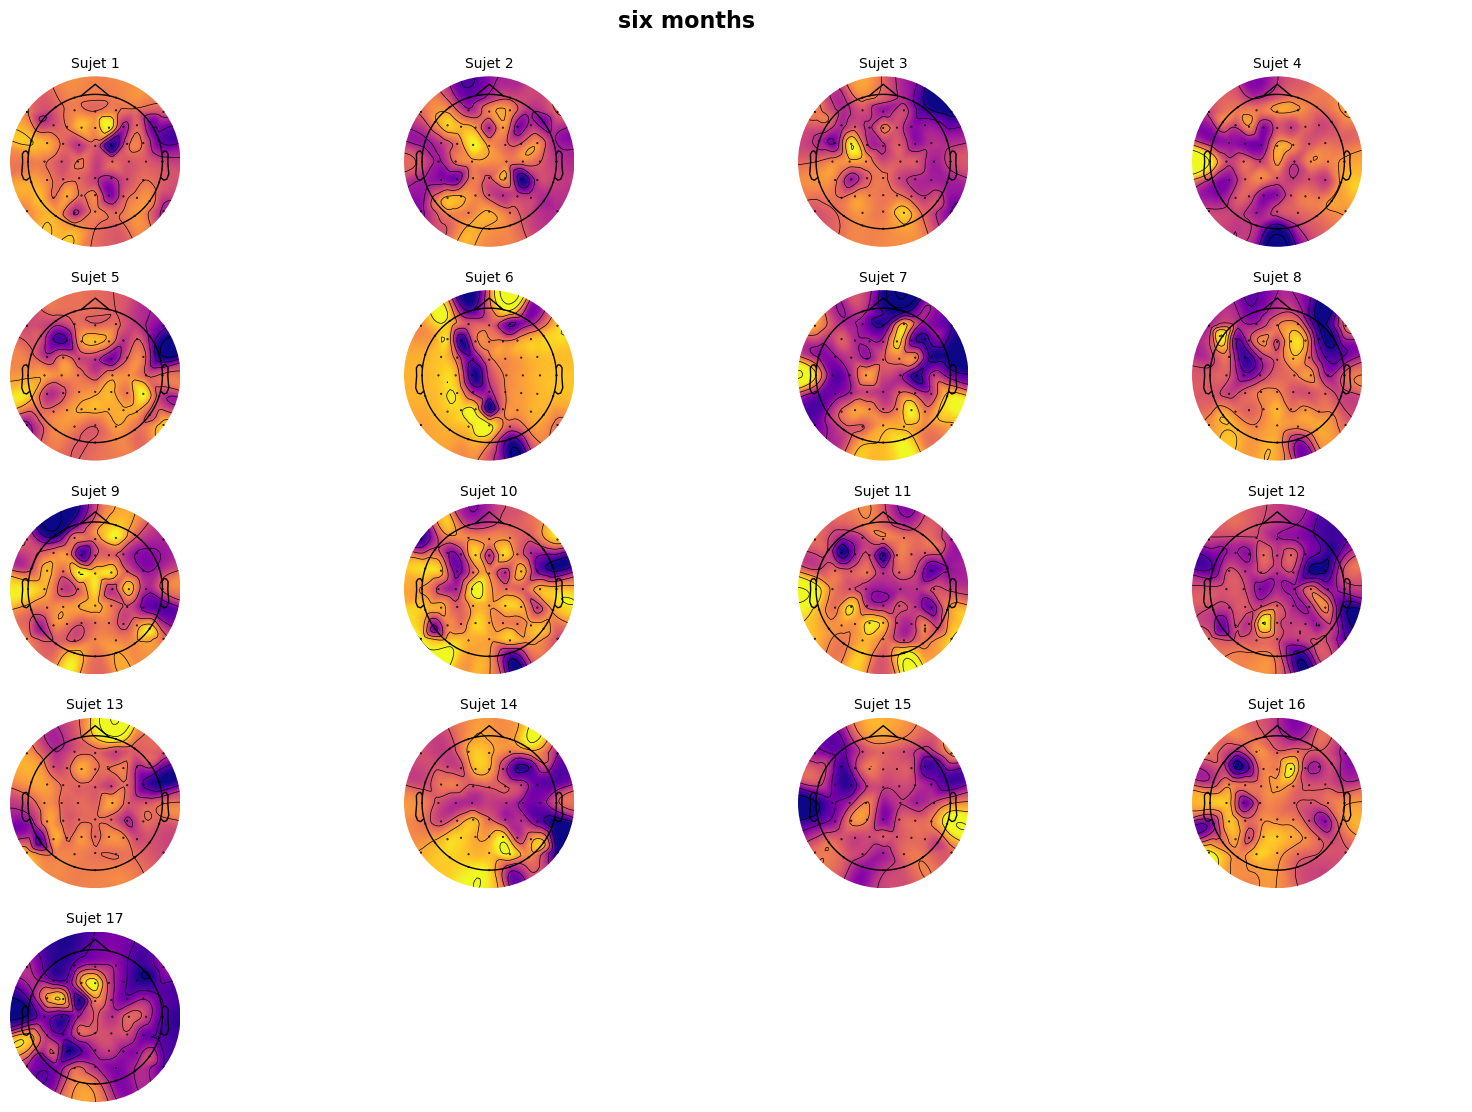

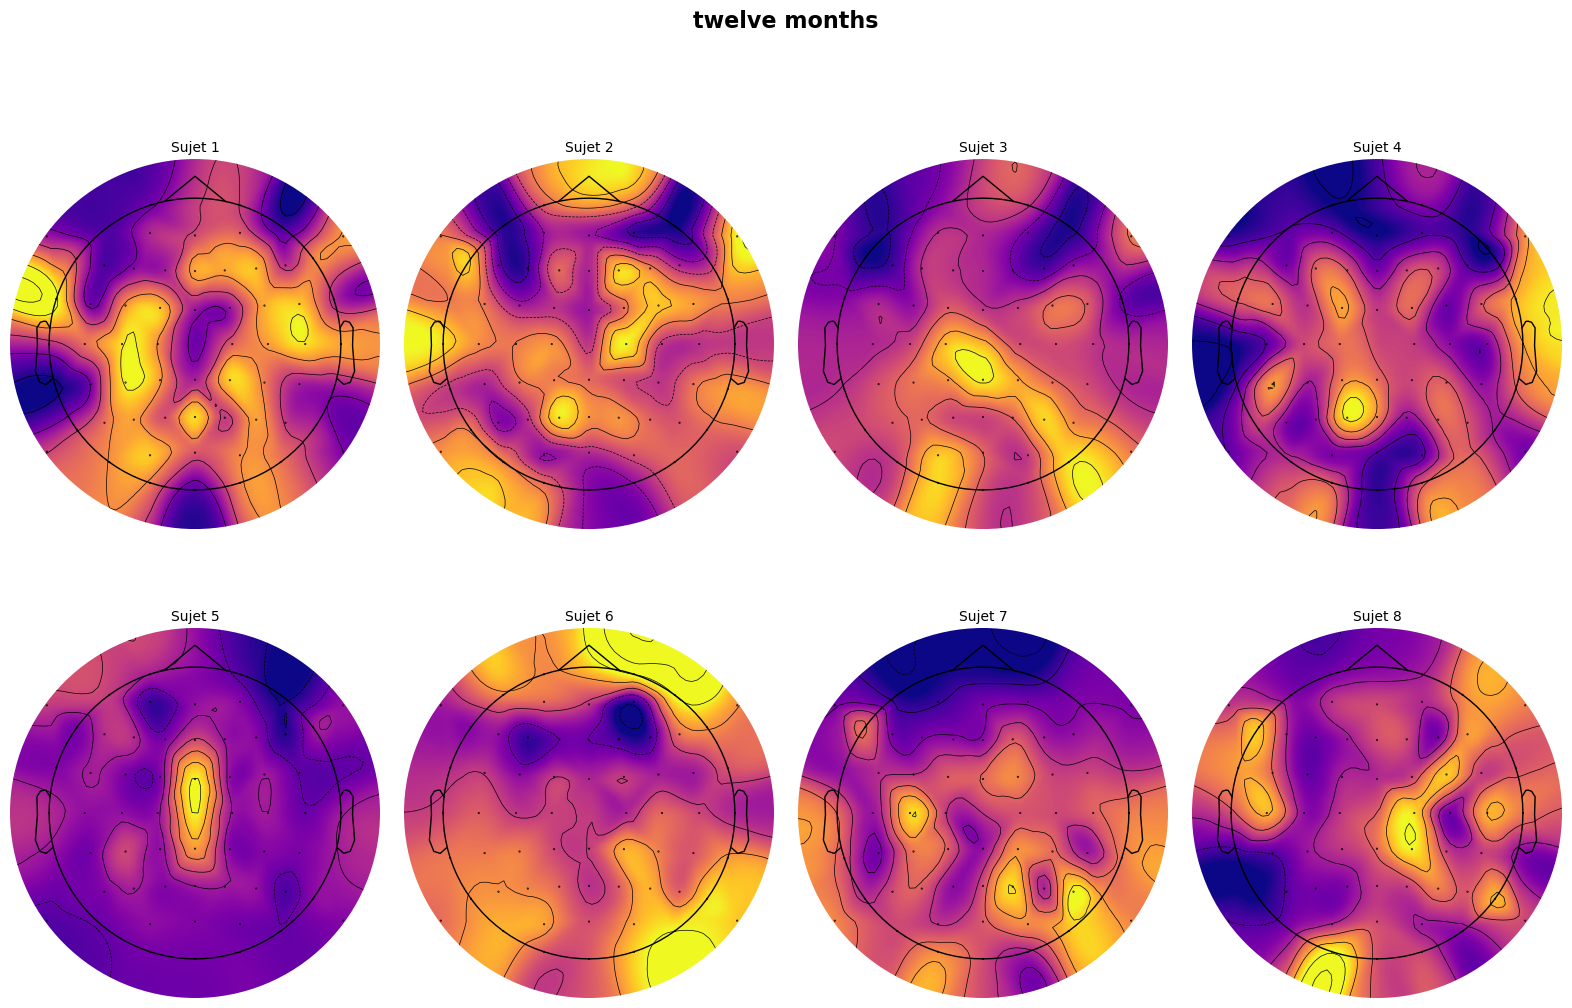

In [15]:
age_intervals = {
    'three': [7.85, 11.95],
    'six': [2.5, 4.9], 
    'twelve': [12., 18.1]
}

for age_idx, age in enumerate(ages):
    fname = file_paths[age]  
    data = scipy.io.loadmat(fname)
    psd = data['periodic']  
    frex = data['frex'][0, :]  
    subjects = psd.shape[0]  

    beta_range = age_intervals[age]
    frex_idx = np.where((frex >= beta_range[0]) & (frex <= beta_range[1]))[0]
    
    fig, axes = plt.subplots(nrows=int(np.ceil(subjects / 4)), ncols=4, figsize=(16, 12))
    fig.suptitle(f'{age} months', fontsize=16, fontweight='bold')

    axes = axes.flatten()  

    for subj_idx in range(subjects):
        subject_psd = psd[subj_idx]  
        
        if subject_psd.ndim == 3:  
            subject_psd = np.nanmean(subject_psd, axis=0)  
        
        elif subject_psd.ndim == 2 and subject_psd.shape[0] == 801:  
            subject_psd = subject_psd.T  

        elif subject_psd.ndim == 1:  
            raise ValueError(f"Les données du sujet {subj_idx} ne contiennent qu'une seule dimension : {subject_psd.shape}")

        mean_beta = np.nanmean(subject_psd[:, frex_idx], axis=1).ravel()  

        ax = axes[subj_idx] if subj_idx < len(axes) else None
        if ax:
            im, _ = mne.viz.plot_topomap(
                mean_beta, info_no_cz, cmap='plasma', axes=ax, show=False,
                contours=6, vlim=(np.min(mean_beta), np.max(mean_beta)),
                sphere= 1.
            )
            ax.set_title(f'Sujet {subj_idx + 1}', fontsize=10) 

  
    for ax_idx in range(subjects, len(axes)):
        axes[ax_idx].axis('off')
    plt.tight_layout(rect=[0, 0.05, 1, 1])  
    plt.show()
